In [1]:
import matplotlib as mpl
#matplotlib.use('Agg')

In [2]:
import os
import datetime
import time
import copy
import shutil
import sys
sys.path.append('/cnrm/pastel/USERS/lecestres/analyse/')
from function_read import *
from HW_detection import *
from forecast_veri import *
import numpy as np

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
from matplotlib.colors import ListedColormap
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import calendar
import locale
locale.setlocale( locale.LC_ALL , 'en_US' )
from netCDF4 import num2date, date2num 
import netCDF4
from math import sin, cos, sqrt, atan2, radians
from sklearn.neighbors import DistanceMetric
from math import radians

from joblib import Parallel, delayed
import joblib

In [3]:
from scipy.stats import pearsonr, spearmanr
from scipy.stats import pearsonr, spearmanr, linregress

def nanpearsonr(x_input,y_input):
    a=x_input.copy()
    b=y_input.copy()
    x,y = [],[]
    for i in range(len(a)):
        if not(np.isnan(a[i])) and not(np.isnan(b[i])):
            x.append(a[i])
            y.append(b[i])
    return(pearsonr(np.array(x), np.array(y)))

def nanspearmanr(x_input,y_input):
    a=x_input.copy()
    b=y_input.copy()
    x,y = [],[]
    for i in range(len(a)):
        if not(np.isnan(a[i])) and not(np.isnan(b[i])):
            x.append(a[i])
            y.append(b[i])
    return(spearmanr(np.array(x), np.array(y)))

def maskpearsonr(x_input, y_input):
    a=x_input.copy()
    b=y_input.copy()
    if (a.mask!=b.mask).any():
        raise ValueError('Input masks are not identical')
    a.data[a.mask]=np.nan
    b.data[b.mask]=np.nan
    return(nanpearsonr(a.data.flatten(), b.data.flatten()))

def maskspearmanr(x_input, y_input):
    a=x_input.copy()
    b=y_input.copy()
    if (a.mask!=b.mask).any():
        raise ValueError('Input masks are not identical')
    a.data[a.mask]=np.nan
    b.data[b.mask]=np.nan
    return(nanspearmanr(a.data.flatten(), b.data.flatten()))

In [4]:
### EXPERIENCE NAME
expname_ref = "ocean_reanalysis_GREP"
expname_tocompare = "sst_retroprevision_sys7"

### PERCENTILE THRESHOLD
percent_thresh = 95
#percent_thresh = 90

### MINIMAL DURATION OF A HW
duration_min = 5
#duration_min = 3

### REGION OF EXPERIENCE

#reg_name = 'north_pacific'
#reg_name = 'north_atlantic'
#reg_name = 'indian_ocean'
#reg_name = 'austral_ocean'
#reg_name = 'tropical_atlantic'
#reg_name = 'tropical_pacific'
reg_name = 'mediterranee'
#reg_name = 'global'


if reg_name == 'north_pacific':
    lats_bnds = np.array([30,65])
    lons_bnds = np.array([120, -120])
    central_lon = 180
    cross_greenwich = False
    cross_antimeridian = True
    reg_name2 = 'Pacific North ocean'
    
if reg_name == 'north_atlantic':
    lats_bnds = np.array([30,65])
    lons_bnds = np.array([-80, 0])
    central_lon = 320
    cross_greenwich = False
    cross_antimeridian = False
    reg_name2 = 'Atlantic North ocean'
    
if reg_name == 'indian_ocean':
    lats_bnds = np.array([-30,30])
    lons_bnds = np.array([45, 110])
    central_lon = 77.5
    cross_greenwich = False
    cross_antimeridian = False
    reg_name2 = 'Indian ocean'
    
if reg_name == 'austral_ocean':
    lats_bnds = np.array([-90,-30])
    lons_bnds = np.array([-180, 180])
    central_lon = 0
    cross_greenwich = True
    cross_antimeridian = False
    reg_name2 = 'Austral ocean'
    
if reg_name == 'tropical_atlantic':
    lats_bnds = np.array([-30,30])
    lons_bnds = np.array([-70, 20])
    central_lon = 335
    cross_greenwich = True
    cross_antimeridian = False
    reg_name2 = 'Atlantic Tropical ocean'
    
if reg_name == 'tropical_pacific':
    lats_bnds = np.array([-30,30])
    lons_bnds = np.array([120, -70])
    central_lon = -155
    cross_greenwich = False
    cross_antimeridian = True
    reg_name2 = 'Pacific Tropical ocean'
    
if reg_name == 'mediterranee':
    lats_bnds = np.array([30,50])
    lons_bnds = np.array([-5, 40])
    central_lon = 17.5
    cross_greenwich = True
    cross_antimeridian = False
    reg_name2 = 'Mediterranean sea'
    
if reg_name == 'global':
    lats_bnds = np.array([-90,90])
    lons_bnds = np.array([-180,180])
    cross_greenwich = True
    cross_antimeridian = False
    reg_name2 = 'Earth'
    
nlat = lats_bnds[1]-lats_bnds[0]
if lons_bnds[1]<lons_bnds[0]:
    nlon = lons_bnds[1]%360-lons_bnds[0]
else:
    nlon = lons_bnds[1]-lons_bnds[0]

### YEARS
if expname_ref == 'ocean_reanalysis_GREP':
    end_year_ref=2016
    start_year_ref=1993
if expname_tocompare == 'sst_retroprevision_sys7':
    end_year_tocompare=2016
    start_year_tocompare=1993

nyear=end_year_tocompare-start_year_tocompare+1

### SEASON
#season = "NDJFMAM"
season = "DJF"
if season == 'NDJFMAM':
    nday = 211
    season_start_day = [11,1] #1stNov
    season_end_day = [5,31] #31stMay
    dayzero = 0
elif season == 'DJF':
    nday = 90
    season_start_day = [12,1] #1stDec
    season_end_day = [3,1] #1stMarch
    first_day = 30
ndayseas = nday//duration_min +1


if expname_ref == "ocean_reanalysis_GREP":    
    ### NUMBER OF MEMBS
    memb_ref=0
    nmemb_ref = 1
    memb_str_ref='memb'+str(memb_ref)
    
    ### CROSS VALIDATION
    cv = True
    if cv:
        cv_str_ref = "CV"
    else:
        cv_str_ref = 'notCV'
        
if expname_tocompare == "sst_retroprevision_sys7":    
    ### NUMBER OF MEMBS
    memb_start_tocompare=0
    memb_end_tocompare=25
    nmemb_tocompare = memb_end_tocompare-memb_start_tocompare
    membs_str_lst_tocompare=['memb'+str(imemb) for imemb in range(nmemb_tocompare)]
           
    ### CROSS VALIDATION
    cv = True
    if cv:
        cv_str_tocompare = "CV"
    else:
        cv_str_tocompare = 'notCV'
    
    

### PARAMETERS
parameters_str_ref = reg_name + "_" + season + "_" + cv_str_ref + '_percent%i'%(percent_thresh) + '_daymin%i'%(duration_min) +  "_ref%i-%i"%(start_year_ref, end_year_ref)+'_'+memb_str_ref
# parameters_str_tocompare = reg_name + "_" + season + "_" + cv_str_tocompare + '_percent%i'%(percent_thresh) + '_daymin%i'%(duration_min) +  "_ref%i-%i"%(start_year_tocompare, end_year_tocompare)
# parameters_tocompare defined later because they dpend on each memb

# Amplitude correlation

In [5]:
topath_ref='Ampli_Fields_'+parameters_str_ref
varname_ref = 'Field'
varname2_ref = 'Ampli'
pathHWMI_ref = '/cnrm/pastel/USERS/lecestres/NO_SAVE/data/'+expname_ref+'/'+memb_str_ref+'/'+season+'/'+topath_ref+'/'
files_ref = glob(pathHWMI_ref + '*.nc')
files_ref.sort()

In [6]:
nHW_max=3
Ampli_ref = np.ma.zeros((nHW_max, nyear))
Fields_ref = np.ma.zeros((nHW_max, nyear, nlat, nlon))
for iyear, file_ref in enumerate(files_ref[:]):
    varf_ref=netCDF4.Dataset(file_ref)
    Fields_ref_iyear=varf_ref[varname_ref][:]
    Ampli_ref_iyear=varf_ref[varname2_ref][:]
    lats_reg=varf_ref['lat'][:]
    lons_reg=varf_ref['lon'][:]
    varf_ref.close()
    nHW_i, ndayseas_i = Ampli_ref_iyear.shape
    if ndayseas != ndayseas_i:
        print('WARNING : ndayseas has been set to ', ndayseas,' but is equal to ', ndayseas_i)
    total_ampli_iyear = np.ma.sum(Ampli_ref_iyear, axis = 1)
    fieldssum_iyear = area_av(Fields_ref_iyear, 1,2, lats_reg, lons_reg)
    args_max_ampli = np.flip(np.argsort(total_ampli_iyear))
    args_max_field = np.flip(np.argsort(fieldssum_iyear))
    if (args_max_ampli[:nHW_max]!=args_max_field[:nHW_max]).all():
        print('WARNING : issue finding the biggest HWs of the iyear : ', iyear)
    for jHW in range(nHW_max):
        Ampli_ref[jHW,iyear]=total_ampli_iyear[args_max_ampli[jHW]]
        Fields_ref[jHW,iyear,:,:]=Fields_ref_iyear[args_max_ampli[jHW],:,:]

In [7]:
Ampli_tocompare = np.ma.zeros((nHW_max, nyear, nmemb_tocompare))
Fields_tocompare = np.ma.zeros((nHW_max, nyear, nmemb_tocompare, nlat, nlon))
files_tocompare_all=[]
for jmemb, jmemb_str in enumerate(membs_str_lst_tocompare):
    parameters_str_tocompare=reg_name+"_"+season+"_"+cv_str_tocompare+'_percent%i'%(percent_thresh)+'_daymin%i'%(duration_min)+"_ref%i-%i"%(start_year_tocompare, end_year_tocompare)+'_'+jmemb_str
    topath_tocompare='Ampli_Fields_'+parameters_str_tocompare
    varname_tocompare = 'Field'
    varname2_tocompare = 'Ampli'
    pathHWMI_tocompare_jmemb = '/cnrm/pastel/USERS/lecestres/NO_SAVE/data/'+expname_tocompare+'/'+jmemb_str+'/'+season+'/'+topath_tocompare+'/'
    files_tocompare_jmemb = glob(pathHWMI_tocompare_jmemb + '*.nc')
    files_tocompare_jmemb.sort()
    files_tocompare_all.append(files_tocompare_jmemb)
    for iyear, file_tocompare in enumerate(files_tocompare_jmemb[:]):
        varf_tocompare=netCDF4.Dataset(file_tocompare)
        Fields_tocompare_iyear_jmemb=varf_tocompare[varname_tocompare][:]
        Ampli_tocompare_iyear_jmemb=varf_tocompare[varname2_tocompare][:]
        lats_reg=varf_ref['lat'][:]
        lons_reg=varf_ref['lon'][:]
        varf_tocompare.close()
        nHW_i_j, ndayseas_i_j = Ampli_tocompare_iyear_jmemb.shape
        if ndayseas != ndayseas_i_j:
            print('WARNING : ndayseas has been set to ', ndayseas,' but is equal to ', ndayseas_i_j)
        total_ampli_iyear_jmemb = np.ma.sum(Ampli_tocompare_iyear_jmemb, axis=1)
        fieldssum_iyear_jmemb = area_av(Fields_tocompare_iyear_jmemb,1,2,lats_reg,lons_reg)
        args_max_ampli = np.flip(np.argsort(total_ampli_iyear_jmemb))
        args_max_field = np.flip(np.argsort(fieldssum_iyear_jmemb))
        if (args_max_ampli[:nHW_max]!=args_max_field[:nHW_max]).all():
            print('WARNING : issue finding the biggest HWs of the iyear, jmemb : ', iyear,jmemb)
        nHW_tmp=min(nHW_max,len(args_max_ampli))
        for lHW in range(nHW_tmp):
            Ampli_tocompare[lHW,iyear,jmemb]=total_ampli_iyear_jmemb[args_max_ampli[lHW]]
            Fields_tocompare[lHW,iyear,jmemb,:,:]=Fields_tocompare_iyear_jmemb[args_max_field[lHW],:,:]

In [65]:
Ampli_mean_tocompare = np.ma.mean(Ampli_tocompare, axis=2)
Fields_mean_tocompare = np.ma.mean(Fields_tocompare, axis=2)
Fields_mean_tocompare.mask = Fields_tocompare.mask[:,:,0,:,:]

maskunion = np.zeros((nlat,nlon))

for i in range(nlat):
    for j in range(nlon):
        trueref = Fields_mean_tocompare.mask[0,0,i,j]
        truetocomp = Fields_ref.mask[0,0,i,j]
        maskunion[i,j] = trueref or truetocomp

for i in range(nyear):
    for hw in range(nHW_max):
        Fields_mean_tocompare.mask[hw,i,:,:]=maskunion
        Fields_ref.mask[hw,i,:,:] = maskunion

Ampli_sum_ref = np.ma.sum(Ampli_ref, axis=0)
Ampli_sum_mean_tocompare = np.ma.sum(Ampli_mean_tocompare, axis=0)
Fields_sum_mean_tocompare = np.ma.sum(Fields_mean_tocompare, axis=0)
Fields_sum_ref = np.ma.sum(Fields_ref, axis=0)

In [66]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import linregress

def predtrend(y):
    nyear, = y.shape
    x=np.arange(nyear)
    modtrend = np.zeros(nyear)
    cortrend = np.zeros((2))
    for iyear in range(nyear):
        xcv=np.delete(x, iyear)
        ycv=np.delete(y, iyear)
        #print(xcv.shape, ycv.shape)
        linreg = linregress(xcv, ycv)
        modtrend[iyear] = x[iyear]*linreg.slope+linreg.intercept
    cortrend[:]=pearsonr(y[:], modtrend[:])
    return(modtrend, cortrend)

Ampli_modtrend, Amplicortrend = predtrend(Ampli_ref[0,:])
Ampli_cor_tocompare = pearsonr(Ampli_ref[0,:],Ampli_mean_tocompare[0,:])
Ampli_sum_modtrend, Ampli_sumcortrend = predtrend(Ampli_sum_ref)
Ampli_sum_cor_tocompare = pearsonr(Ampli_sum_ref, Ampli_sum_mean_tocompare)

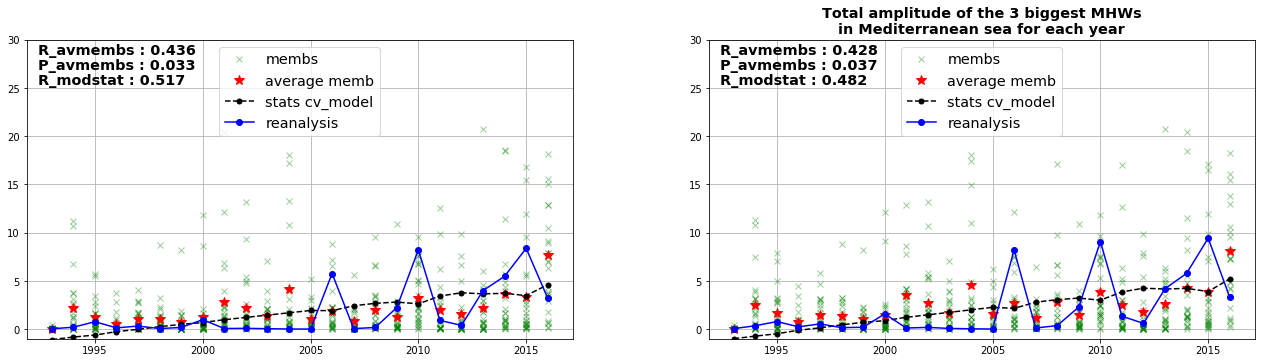

In [67]:
export_path='Ampli_biggestHW_pearsoncorr_'+reg_name
coeff = 1.2

fig = plt.figure(constrained_layout=False, figsize = (22,5.5))
gs = gridspec.GridSpec(1, 2, hspace=0.4, wspace=0.25, figure = fig)

ax1 = plt.subplot(gs[0,0])
ax1.set_ylim((-1,30))
ax1.plot(range(start_year_ref,end_year_ref+1), Ampli_tocompare[0,:,0], 'gx', alpha = 0.4, label = 'membs')
for jmemb in range(1,nmemb_tocompare):
    ax1.plot(range(start_year_ref,end_year_ref+1), Ampli_tocompare[0,:,jmemb], 'gx', alpha = 0.4)
ax1.plot(range(start_year_ref, end_year_ref+1), Ampli_mean_tocompare[0,:], 'r*', markersize = 10, label = 'average memb')
ax1.plot(range(start_year_ref, end_year_ref+1), Ampli_modtrend[:], 'ok--', markersize = 5, label = 'stats cv_model')
ax1.plot(range(start_year_ref, end_year_ref+1), Ampli_ref[0,:], 'bo-', label = 'reanalysis')
ax1.grid()

ax1.annotate('R_avmembs : {:.3f}'.format(Ampli_cor_tocompare[0]), xy=(0.02, 0.95), xycoords='axes fraction', fontsize=12*coeff, fontweight='demibold')
ax1.annotate('P_avmembs : {:.3f}'.format(Ampli_cor_tocompare[1]), xy=(0.02, 0.90), xycoords='axes fraction', fontsize=12*coeff, fontweight='demibold')
ax1.annotate('R_modstat : {:.3f}'.format(Amplicortrend[0]), xy=(0.02, 0.85), xycoords='axes fraction', fontsize=12*coeff, fontweight='demibold')
#ax1.set_title('Amplitude of the biggest MHW in '+reg_name2+'\nfor each year', fontsize = 12*coeff, family='sans-serif',fontweight='demibold')
ax1.legend(fontsize = 12*coeff, loc='upper center')


ax2 = plt.subplot(gs[0,1])
ax2.plot(range(start_year_ref,end_year_ref+1), np.sum(Ampli_tocompare[:,:,0], axis=0), 'gx', alpha = 0.4, label = 'membs')
for jmemb in range(1,nmemb_tocompare):
    ax2.plot(range(start_year_ref,end_year_ref+1), np.sum(Ampli_tocompare[:,:,jmemb],axis=0), 'gx', alpha = 0.4)
ax2.plot(range(start_year_ref, end_year_ref+1), Ampli_sum_mean_tocompare[:], 'r*', markersize = 10, label = 'average memb')
ax2.plot(range(start_year_ref, end_year_ref+1), Ampli_sum_modtrend[:], 'ok--', markersize = 5, label = 'stats cv_model')
ax2.plot(range(start_year_ref, end_year_ref+1), Ampli_sum_ref[:], 'bo-', label = 'reanalysis')
ax2.grid()
ax2.set_ylim(-1,30)
ax2.annotate('R_avmembs : {:.3f}'.format(Ampli_sum_cor_tocompare[0]), xy=(0.02, 0.95), xycoords='axes fraction', fontsize=12*coeff, fontweight='demibold')
ax2.annotate('P_avmembs : {:.3f}'.format(Ampli_sum_cor_tocompare[1]), xy=(0.02, 0.90), xycoords='axes fraction', fontsize=12*coeff, fontweight='demibold')
ax2.annotate('R_modstat : {:.3f}'.format(Ampli_sumcortrend[0]), xy=(0.02, 0.85), xycoords='axes fraction', fontsize=12*coeff, fontweight='demibold')
ax2.set_title('Total amplitude of the '+str(nHW_max)+' biggest MHWs\nin '+reg_name2+' for each year', fontsize = 12*coeff, family='sans-serif',fontweight='demibold')
ax2.legend(fontsize = 12*coeff, loc='upper center')
plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/amplitude/'+export_path+'.pdf')

In [12]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import linregress

def predtrend(y):
    nyear, = y.shape
    x=np.arange(nyear)
    modtrend = np.zeros(nyear)
    cortrend = np.zeros((2))
    for iyear in range(nyear):
        xcv=np.delete(x, iyear)
        ycv=np.delete(y, iyear)
        #print(xcv.shape, ycv.shape)
        linreg = linregress(xcv, ycv)
        modtrend[iyear] = x[iyear]*linreg.slope+linreg.intercept
    cortrend[:]=pearsonr(y[:], modtrend[:])
    return(modtrend, cortrend)

Ampli_modtrend, Amplicortrend = predtrend(Ampli_ref[0,:])
Ampli_cor_tocompare = pearsonr(Ampli_ref[0,:],Ampli_mean_tocompare[0,:])
Ampli_sum_modtrend, Ampli_sumcortrend = predtrend(Ampli_sum_ref)
Ampli_sum_cor_tocompare = pearsonr(Ampli_sum_ref, Ampli_sum_mean_tocompare)

Field_cor = np.zeros((nyear,2))
Field_cor_spearman = np.zeros((nyear,2))
for iyear in range(nyear):
    Field_cor[iyear,:] = maskpearsonr(Fields_mean_tocompare[0,iyear,:,:].flatten(), Fields_ref[0,iyear,:,:].flatten())
    Field_cor_spearman[iyear,:] = maskspearmanr(Fields_mean_tocompare[0,iyear,:,:].flatten(), Fields_ref[0,iyear,:,:].flatten())

In [13]:
cmap = mpl.cm.Reds
color = cmap(np.linspace(0,1,256))
white = np.array([1,1,1,1])
color[:5, :] = white
newcmp = ListedColormap(color)
bounds = np.linspace(0,20,21)
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)
norm = mpl.colors.BoundaryNorm(bounds, newcmp.N, clip=True)

In [14]:
def plotfield(ax, lon, lat, field, title): #, title, bounds, cmin, cmax, cmap, norm, cbar=True, signi=False, signicor=False, extend="neither"):
    #ax.set_extent([lon[0], lon[-1], lat[-1], lat[0]], crs=ccrs.PlateCarree())
    if cross_greenwich:
        lon[lon>180]=lon[lon>180]-360
    elif cross_antimeridian:
        #lat[lat>180]=lat[lat>180]-360
        lon[lon<0]=lon[lon<0]+360
    lon2d, lat2d = np.meshgrid(lon, lat)
    ax.set_extent([lon[0], lon[-1], lat[-1], lat[0]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.coastlines()
    plot = ax.contourf(lon2d, lat2d, field, bounds, transform=ccrs.PlateCarree(), cmap = newcmp, norm=norm, extend='both')
    cbar = fig.colorbar(plot, orientation = 'horizontal', ax=ax, shrink=0.8, spacing='proportional', ticks=[0,10,20])
    ax.set_title(title, fontsize= 10)

In [15]:
coeff = 1
range_year = range(start_year_ref, end_year_ref+1)
year_to_plot_best=np.argmax(Field_cor[:,0])+start_year_ref
year_to_plot_worse=np.argmin(Field_cor[:,0])+start_year_ref
year_to_plot_medium=np.argsort(Field_cor[:,0])[nyear//2]+start_year_ref

Text(0.5,1.03,'Spatial correlations for the biggest MHW of each year')

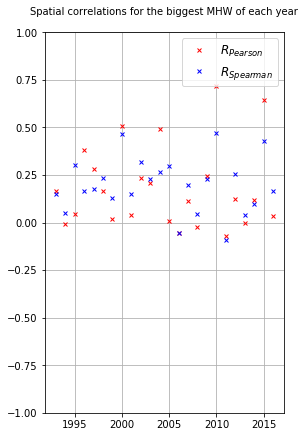

In [16]:
fig = plt.figure(constrained_layout=False, figsize = (15,7))

gs = gridspec.GridSpec(2, 3, hspace=0.4, wspace=0.25, figure = fig)

ax1 = plt.subplot(gs[:,2])

ax1.plot(range_year, Field_cor[:,0], 'rx', markersize=4*coeff, alpha = 1 , label = r'${R_{Pearson}}$')
ax1.plot(range_year, Field_cor_spearman[:,0], 'bx', markersize=4*coeff, alpha = 1 , label = r'${R_{Spearman}}$')
ax1.grid()
ax1.tick_params(axis='both', labelsize=10*coeff)

ax1.set_ylim((-1,1))
ax1.legend(fontsize = 12*coeff)
ax1.set_title('Spatial correlations for the biggest MHW of each year', fontsize = 10*coeff, y=1.03)

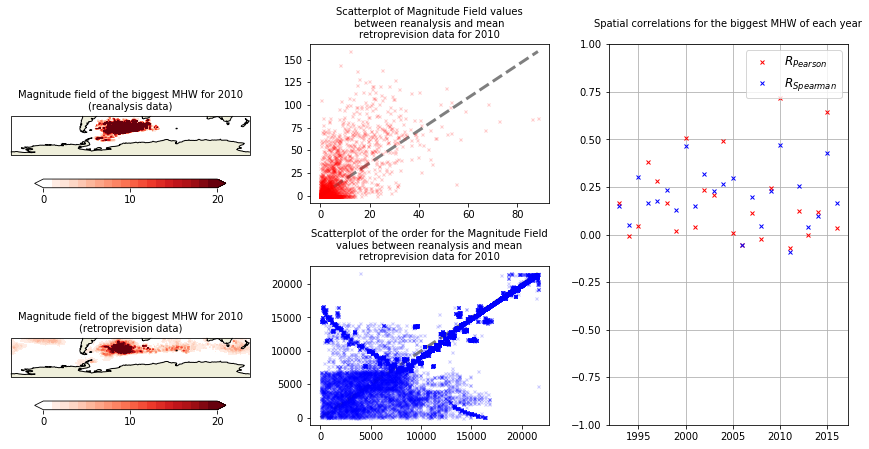

In [18]:
coeff = 1
range_year = range(start_year_ref, end_year_ref+1)
year_to_plot=2010
year_to_plot2=1993
str_year=str(year_to_plot)
str_year2=str(year_to_plot2)


fig = plt.figure(constrained_layout=False, figsize = (15,7))

gs = gridspec.GridSpec(2, 3, hspace=0.4, wspace=0.25, figure = fig)

ax1 = plt.subplot(gs[:,2])

ax1.plot(range_year, Field_cor[:,0], 'rx', markersize=4*coeff, alpha = 1 , label = r'${R_{Pearson}}$')
ax1.plot(range_year, Field_cor_spearman[:,0], 'bx', markersize=4*coeff, alpha = 1 , label = r'${R_{Spearman}}$')
ax1.grid()
ax1.tick_params(axis='both', labelsize=10*coeff)

ax1.set_ylim((-1,1))
ax1.legend(fontsize = 12*coeff)
ax1.set_title('Spatial correlations for the biggest MHW of each year', fontsize = 10*coeff, y=1.03)

ax2 = plt.subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield(ax2, lons_reg, lats_reg, Fields_ref[0,year_to_plot-start_year_ref,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(reanalysis data)')

ax3 = plt.subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=central_lon))
plotfield(ax3, lons_reg, lats_reg, Fields_mean_tocompare[0,year_to_plot-start_year_ref,:,:], 'Magnitude field of the biggest MHW for '+str_year+'\n(retroprevision data)')

ax4 = plt.subplot(gs[0,1])
line4 = [np.max(Fields_mean_tocompare[0,year_to_plot-start_year_ref,:,:]), np.max(Fields_ref[0,year_to_plot-start_year_ref,:,:])]
ax4.plot([0,line4[0]],[0, line4[1]], 'k--', linewidth=3, alpha=0.5)
ax4.plot(Fields_mean_tocompare[0,year_to_plot-start_year_ref,:,:].flatten(), Fields_ref[0,year_to_plot-start_year_ref,:,:].flatten(), 'rx', markersize=3, alpha=0.2)
ax4.set_title('Scatterplot of Magnitude Field values\nbetween reanalysis and mean\nretroprevision data for '+ str_year, fontsize = 10*coeff)


ax5 = plt.subplot(gs[1,1])
line5 = len(Fields_mean_tocompare[0,year_to_plot-start_year_ref,:,:].flatten())
ax5.plot([0,line5],[0, line5], 'k--', linewidth=3, alpha=0.5)
ax5.plot(np.argsort(Fields_mean_tocompare[0,year_to_plot-start_year_ref,:,:].flatten()), np.argsort(Fields_ref[0,year_to_plot-start_year_ref,:,:].flatten()), 'bx', markersize=3, alpha=0.2)
ax5.set_title('Scatterplot of the order for the Magnitude Field\nvalues between reanalysis and mean\nretroprevision data for '+ str_year, fontsize = 10*coeff)


export_path='Correlation_results_'+reg_name
#plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/'+export_path+'.pdf')


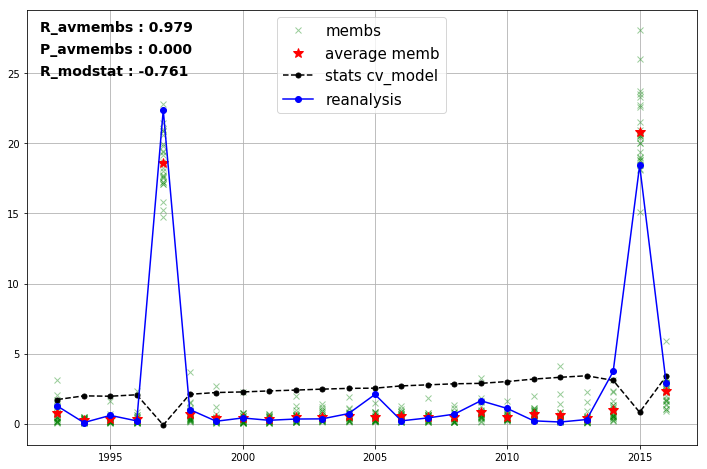

In [18]:
export_path='Ampli_biggestHW_pearsoncorr_'+reg_name
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(start_year_ref,end_year_ref+1), Ampli_tocompare[0,:,0], 'gx', alpha = 0.4, label = 'membs')
for jmemb in range(1,nmemb_tocompare):
    ax.plot(range(start_year_ref,end_year_ref+1), Ampli_tocompare[0,:,jmemb], 'gx', alpha = 0.4)
ax.plot(range(start_year_ref, end_year_ref+1), Ampli_mean_tocompare[0,:], 'r*', markersize = 10, label = 'average memb')
ax.plot(range(start_year_ref, end_year_ref+1), Ampli_modtrend[:], 'ok--', markersize = 5, label = 'stats cv_model')
ax.plot(range(start_year_ref, end_year_ref+1), Ampli_ref[0,:], 'bo-', label = 'reanalysis')
ax.grid()
ax.annotate('R_avmembs : {:.3f}'.format(Ampli_cor_tocompare[0]), xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14, fontweight='demibold')
ax.annotate('P_avmembs : {:.3f}'.format(Ampli_cor_tocompare[1]), xy=(0.02, 0.90), xycoords='axes fraction', fontsize=14, fontweight='demibold')
ax.annotate('R_modstat : {:.3f}'.format(Amplicortrend[0]), xy=(0.02, 0.85), xycoords='axes fraction', fontsize=14, fontweight='demibold')
#fig.suptitle('Amplitude of the biggest MHW in '+reg_name+' for each year', fontsize = 20, family='sans-serif',fontweight='demibold')
ax.legend(fontsize = 15, loc='upper center')
ax.set_ylim=((-1,30))
#plt.savefig('/cnrm/pastel/USERS/lecestres/NO_SAVE/plots/amplitude/'+export_path+'.pdf')